# 19th Century German Corpus

### First of all I import all the packages I need and create the stopword list

In [54]:
import glob
import os

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','ha','sagen','kommen','sprechen','scheinen','finden',
                  'mua_te', 'wua_te','a¼ber', 'tun', 'finden','bleiben','hum_ind_who', 'num_date_when', 'ka_nnen', 'ka_niginn',
                  'lassen','sollen','ziehen','nehmen','rufen','geben','stehen','halten','_',
                  'ma_dchen','tag','illustration','scha_nen',
                  'ka_nne','wa¼rden','ma_chte','bringen','mögen','liegen'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [34]:
textfiles = glob.glob("German19C/*txt") # list files in local directory

In [35]:
textList=[]
for textFile in textfiles: # create a list 
    f = open(textFile, "r")
    textList = textList + [f.read().upper()]
    f.close()
len(textList)

74

# Pre-processing the texts

### trasnform umlaut to non-diacritic

In [36]:
# dictionary of umlaut unicode representations (keys) and their replacements (values)
umlautDictionary = {u'Ä': 'Ae',
                    u'Ö': 'Oe',
                    u'Ü': 'Ue',
                    u'ä': 'ae',
                    u'ö': 'oe',
                    u'ü': 'ue'
                    }

In [37]:
# translate all diacritcs to non-diacritic
umap = {ord(key):str(val) for key, val in umlautDictionary.items()}
for text in textList:
    text = text.translate(umap)

### tokenize the texts, remove punctuation and unnessecary characters

In [40]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
data_words = list(sent_to_words(textList))

In [41]:
import spacy
nlp = spacy.load("de_core_news_sm", disable=['parser', 'ner'])

### Building bigram and trigram models, words that are likely to occur together

In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Remove stopwords, make bigrams and bigrams and lemmatize

In [55]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN','VERB']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

### Create dictionary and corpus needed for the Topic Model, build LDA model

In [56]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=10,
                                           per_word_topics=True)

### View the top 10 topics in the LDA model

In [57]:
pprint(lda_model.print_topics())

[(0,
  '0.024*"sehen" + 0.020*"gehen" + 0.009*"zeit" + 0.007*"leben" + 0.006*"herr" '
  '+ 0.005*"haus" + 0.005*"denken" + 0.005*"tragen" + 0.004*"treten" + '
  '0.004*"stadt"'),
 (1,
  '0.021*"sehen" + 0.014*"gehen" + 0.008*"leben" + 0.008*"zeit" + '
  '0.005*"glauben" + 0.005*"denken" + 0.004*"recht" + 0.004*"dürfen" + '
  '0.004*"tragen" + 0.004*"stadt"'),
 (2,
  '0.026*"sehen" + 0.019*"gehen" + 0.010*"zeit" + 0.007*"denken" + '
  '0.006*"leben" + 0.006*"glauben" + 0.005*"fallen" + 0.005*"gesicht" + '
  '0.005*"recht" + 0.004*"menschen"'),
 (3,
  '0.034*"gehen" + 0.027*"sehen" + 0.010*"zeit" + 0.007*"denken" + '
  '0.006*"leben" + 0.006*"menschen" + 0.005*"haus" + 0.005*"tragen" + '
  '0.005*"herr" + 0.005*"zeigen"'),
 (4,
  '0.026*"sehen" + 0.013*"gehen" + 0.010*"herr" + 0.008*"zeit" + 0.007*"leben" '
  '+ 0.007*"denken" + 0.005*"setzen" + 0.005*"fahren" + 0.005*"zeigen" + '
  '0.005*"glauben"'),
 (5,
  '0.025*"sehen" + 0.016*"gehen" + 0.009*"leben" + 0.008*"zeit" + '
  '0.005*"men

# Visualization

## Word clouds of top n keywords in each topic

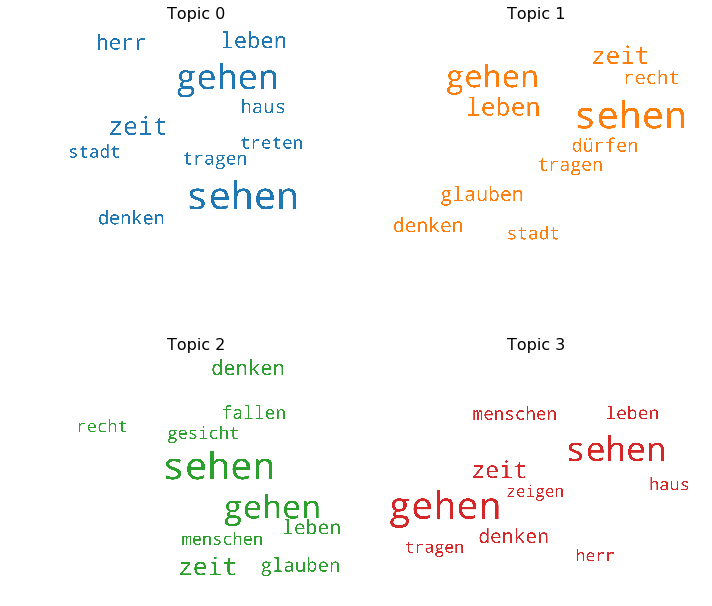

In [58]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Dominant topic and its percentage contribution in each document

In [60]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=textList):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.8258,"sehen, gehen, leben, zeit, menschen, glauben, ...","[kinderland, novellen, novellen, insel_verlag,..."
1,1,0.0,0.7196,"sehen, gehen, zeit, leben, herr, haus, denken,...","[gehorigen, schlossgarten, gespenstisch, allee..."
2,2,9.0,0.3469,"gehen, sehen, leben, zeit, denken, herr, wisse...","[aufsatze, lachen, lacheln, sachen, schreiben,..."
3,3,6.0,0.3582,"sehen, gehen, leben, zeit, denken, herr, glaub...","[malen, malen, sehen, entwicklung, warnen, auf..."
4,4,9.0,0.5659,"gehen, sehen, leben, zeit, denken, herr, wisse...","[verlag, kirche, ausnehmen, tage, triefen, bah..."
5,5,1.0,0.7634,"sehen, gehen, leben, zeit, glauben, denken, re...","[frau, gleich_danach, fenstern, sassen, damen,..."
6,6,3.0,0.8118,"gehen, sehen, zeit, denken, leben, menschen, h...","[wagen, voruberfahren, sehen, lucken, heissen,..."
7,7,8.0,0.7207,"sehen, gehen, zeit, leben, denken, glauben, he...","[buch, insel_verlag, eingang, tritt, stube, we..."
8,8,5.0,0.9525,"sehen, gehen, leben, zeit, menschen, glauben, ...","[grossen, reich, eroffneten, magern, schimmeln..."
9,9,3.0,0.6875,"gehen, sehen, zeit, denken, leben, menschen, h...","[erzahlung, insel_verlag, schreien, erreichen,..."


## The most representative sentence for each topic

In [61]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9915,"sehen, gehen, zeit, leben, herr, haus, denken, tragen, treten, stadt","[herausgeben, einleiten, kammer, traum, lied, ertonte, nachtgen, schlagen, ergotzt, brust, wache..."
1,1.0,0.9542,"sehen, gehen, leben, zeit, glauben, denken, recht, dürfen, tragen, stadt","[embrassieren, totet, steigen, fromm, hutten, brust, wehen, steigen, ragen, singen, jagen, stadt..."
2,2.0,0.9304,"sehen, gehen, zeit, denken, leben, glauben, fallen, gesicht, recht, menschen","[seldwyla, bedeuten, sonnig, stadt, stecken, ringmauern, turmen, jahren, absicht, anlage, umstan..."
3,3.0,0.9609,"gehen, sehen, zeit, denken, leben, menschen, haus, tragen, herr, zeigen","[steine, tragen, hause, freuen, farbe, bestand, pflanzen, steine, feldern, hutweiden, weisen, fr..."
4,4.0,0.9856,"sehen, gehen, herr, zeit, leben, denken, setzen, fahren, zeigen, glauben","[fabrikstadt, hintergrund, biegung, hause, sehen, erbleichen, frau_amanda, recht, furn, gesellen..."
5,5.0,0.9865,"sehen, gehen, leben, zeit, menschen, glauben, stadt, denken, fahren, setzen","[stefan, balzac, zehn_jahren, binden, versuche, balzac, absicht, versuchen, grossen, sinne, type..."
6,6.0,0.5519,"sehen, gehen, leben, zeit, denken, herr, glauben, wissen, recht, dürfen","[gransee, rheinsberg, meilen, dorfern, teerofen, bilden, heisst, stelle, buchen, eingefasst, ber..."
7,7.0,0.9676,"sehen, gehen, herr, leben, treten, stadt, setzen, tragen, zeit, augenblick","[ausgewahlte, schriften, kleist, befinden, trummern, sehen, zimmern, hausfrau, betten, absetzen,..."
8,8.0,0.9381,"sehen, gehen, zeit, leben, denken, glauben, herr, fallen, fahren, tragen","[lebensansichten, hausbibliothek, bildung, lebensansichten, januar, gebären, besetzung, verliere..."
9,9.0,0.9891,"gehen, sehen, leben, zeit, denken, herr, wissen, fahren, glauben, beginnen","[erweisen, erfolgen, stellen, mondklaren, nacht, opfer, einbiegen, kalte, nachtluft, schmar, roc..."


## Word counts of topic keywords, scaled by weigh (importance) 

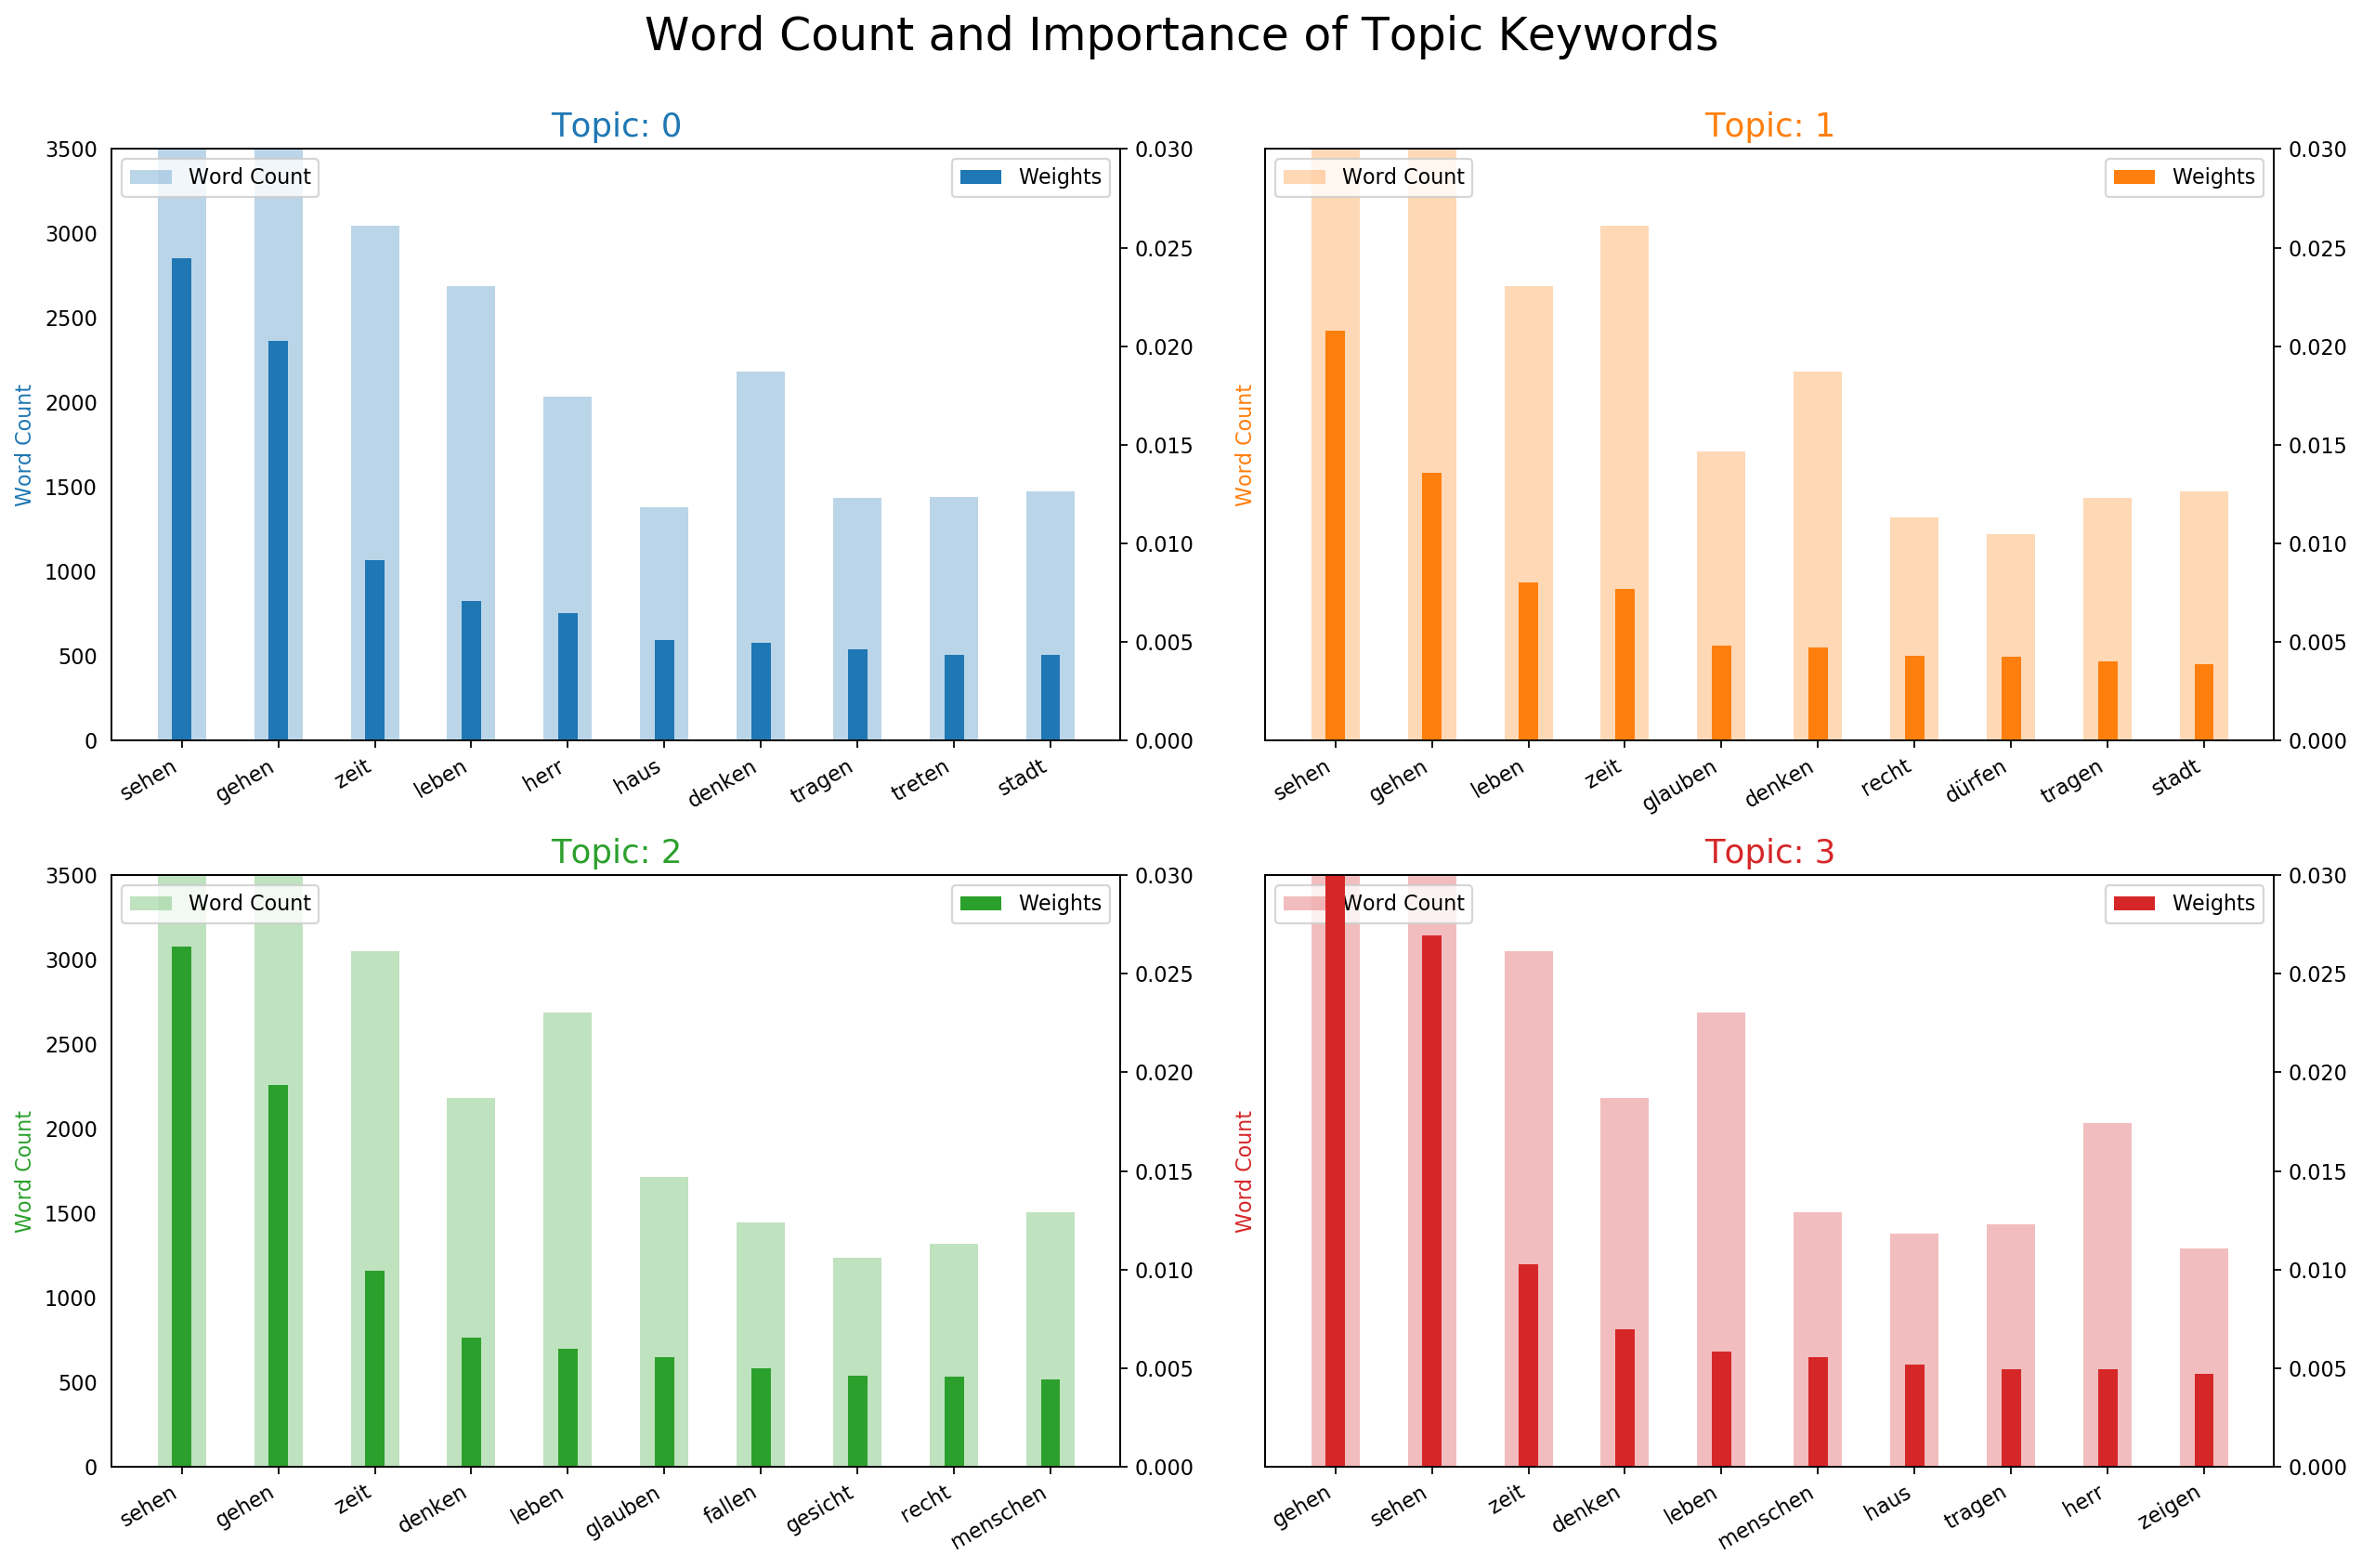

In [62]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## pyLDAVIS: Visualise the information contained in a topic

In [64]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.033133  0.028922       1        1  23.209673
5      0.003061  0.018965       2        1  17.734686
9     -0.036487  0.017512       3        1  14.897024
4     -0.008033  0.004545       4        1  10.057945
8      0.007600 -0.045977       5        1   8.133886
7     -0.024334 -0.005576       6        1   7.247872
2     -0.004672  0.018037       7        1   5.748758
0      0.052594 -0.005622       8        1   5.653324
1      0.005767 -0.018290       9        1   4.012809
6     -0.028628 -0.012515      10        1   3.304023, topic_info=      Category         Freq         Term        Total  loglift  logprob
1688   Default  7749.000000        sehen  7749.000000  30.0000  30.0000
838    Default  6811.000000        gehen  6811.000000  29.0000  29.0000
2367   Default  2808.000000         zeit  2808.000000  28.0000  28.0000
1253   Default  2463.000000        leben  2463.000000  27.0000  27.0000
985    Default  1869.000000         herr  1869.000000  26.0000  26.0000
905    Default  1570.000000      glauben  1570.000000  25.0000  25.0000
440    Default  2031.000000       denken  2031.000000  24.0000  24.0000
3002   Default  1203.000000        recht  1203.000000  23.0000  23.0000
874    Default  1135.000000      gesicht  1135.000000  22.0000  22.0000
1925   Default  1315.000000       tragen  1315.000000  21.0000  21.0000
683    Default  1315.000000       fallen  1315.000000  20.0000  20.0000
493    Default  1126.000000       dürfen  1126.000000  19.0000  19.0000
1940   Default  1320.000000       treten  1320.000000  18.0000  18.0000
2328   Default  1413.000000       wissen  1413.000000  17.0000  17.0000
1761   Default  1358.000000        stadt  1358.000000  16.0000  16.0000
223    Default   934.000000     beginnen   934.000000  15.0000  15.0000
1783   Default   676.000000      steigen   676.000000  14.0000  14.0000
156    Default  1053.000000   augenblick  1053.000000  13.0000  13.0000
678    Default  1444.000000       fahren  1444.000000  12.0000  12.0000
2364   Default  1192.000000       zeigen  1192.000000  11.0000  11.0000
23733  Default   124.000000  penthesilea   124.000000  10.0000  10.0000
1404   Default   880.000000       nennen   880.000000   9.0000   9.0000
972    Default   426.000000       heisst   426.000000   8.0000   8.0000
20147  Default    93.000000      engelke    93.000000   7.0000   7.0000
1649   Default  1107.000000    schreiben  1107.000000   6.0000   6.0000
1390   Default   998.000000        nacht   998.000000   5.0000   5.0000
2136   Default  1016.000000    verstehen  1016.000000   4.0000   4.0000
1787   Default  1032.000000      stellen  1032.000000   3.0000   3.0000
1615   Default   772.000000     schlagen   772.000000   2.0000   2.0000
1544   Default   156.000000        rosen   156.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
838    Topic10   155.370361        gehen  6811.983398  -0.3706  -4.2636
1253   Topic10    85.141945        leben  2463.251221   0.0451  -4.8650
905    Topic10    61.927158      glauben  1570.162842   0.1771  -5.1834
2328   Topic10    55.752419       wissen  1413.546753   0.1771  -5.2884
493    Topic10    47.585194       dürfen  1126.071533   0.2461  -5.4468
985    Topic10    62.771526         herr  1869.810791   0.0159  -5.1699
2367   Topic10    78.293701         zeit  2808.140137  -0.1698  -4.9489
3002   Topic10    48.692150        recht  1203.157959   0.2028  -5.4238
440    Topic10    63.780403       denken  2031.435181  -0.0510  -5.1539
3406   Topic10    24.943428     bisschen   373.092865   0.7048  -6.0928
874    Topic10    44.193436      gesicht  1135.398926   0.1639  -5.5208
223    Topic10    39.658989     beginnen   934.443604   0.2504  -5.6290
1787   Topic10    40.403076      stellen  1032.640869   0.1691  -5.6105
425    Topic10    17.227922        damen   195.726898   0.9798  -6.46

### Keeping only nouns

In [65]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [68]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           chunksize=1000,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=10,
                                           per_word_topics=True)

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

### View 10 most important topics

In [69]:
pprint(lda_model.print_topics())

[(0,
  '0.059*"herr" + 0.035*"recht" + 0.034*"zeit" + 0.023*"haus" + 0.021*"nacht" '
  '+ 0.021*"erde" + 0.019*"stadt" + 0.018*"apo" + 0.012*"ende" + 0.010*"bild"'),
 (1,
  '0.058*"herr" + 0.052*"zeit" + 0.023*"stadt" + 0.018*"augenblick" + '
  '0.018*"arbeit" + 0.018*"haus" + 0.014*"recht" + 0.013*"emmi" + '
  '0.012*"hause" + 0.012*"menschen"'),
 (2,
  '0.042*"herr" + 0.035*"zeit" + 0.023*"stadt" + 0.022*"augenblick" + '
  '0.019*"recht" + 0.019*"hause" + 0.017*"haus" + 0.014*"sache" + '
  '0.013*"nacht" + 0.010*"ende"'),
 (3,
  '0.036*"nacht" + 0.034*"zeit" + 0.029*"haus" + 0.028*"menschen" + '
  '0.026*"augenblick" + 0.021*"herr" + 0.019*"stadt" + 0.013*"jahre" + '
  '0.013*"recht" + 0.012*"erde"'),
 (4,
  '0.058*"zeit" + 0.039*"herr" + 0.035*"menschen" + 0.034*"haus" + '
  '0.030*"recht" + 0.029*"nacht" + 0.021*"augenblick" + 0.020*"stadt" + '
  '0.016*"hause" + 0.013*"ende"'),
 (5,
  '0.056*"menschen" + 0.045*"zeit" + 0.018*"stadt" + 0.016*"augenblick" + '
  '0.015*"recht" + 0.01

## Word clouds of top n keywords in each topic

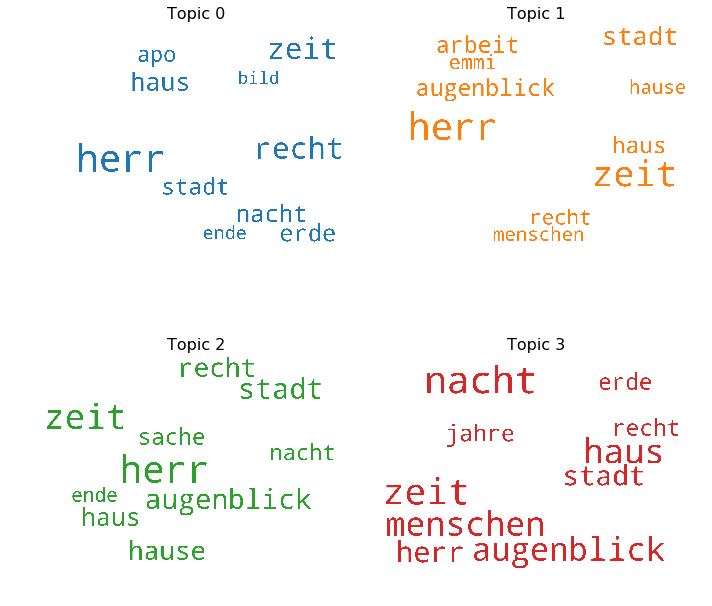

In [71]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word counts of topic keywords, scaled by weigh (importance

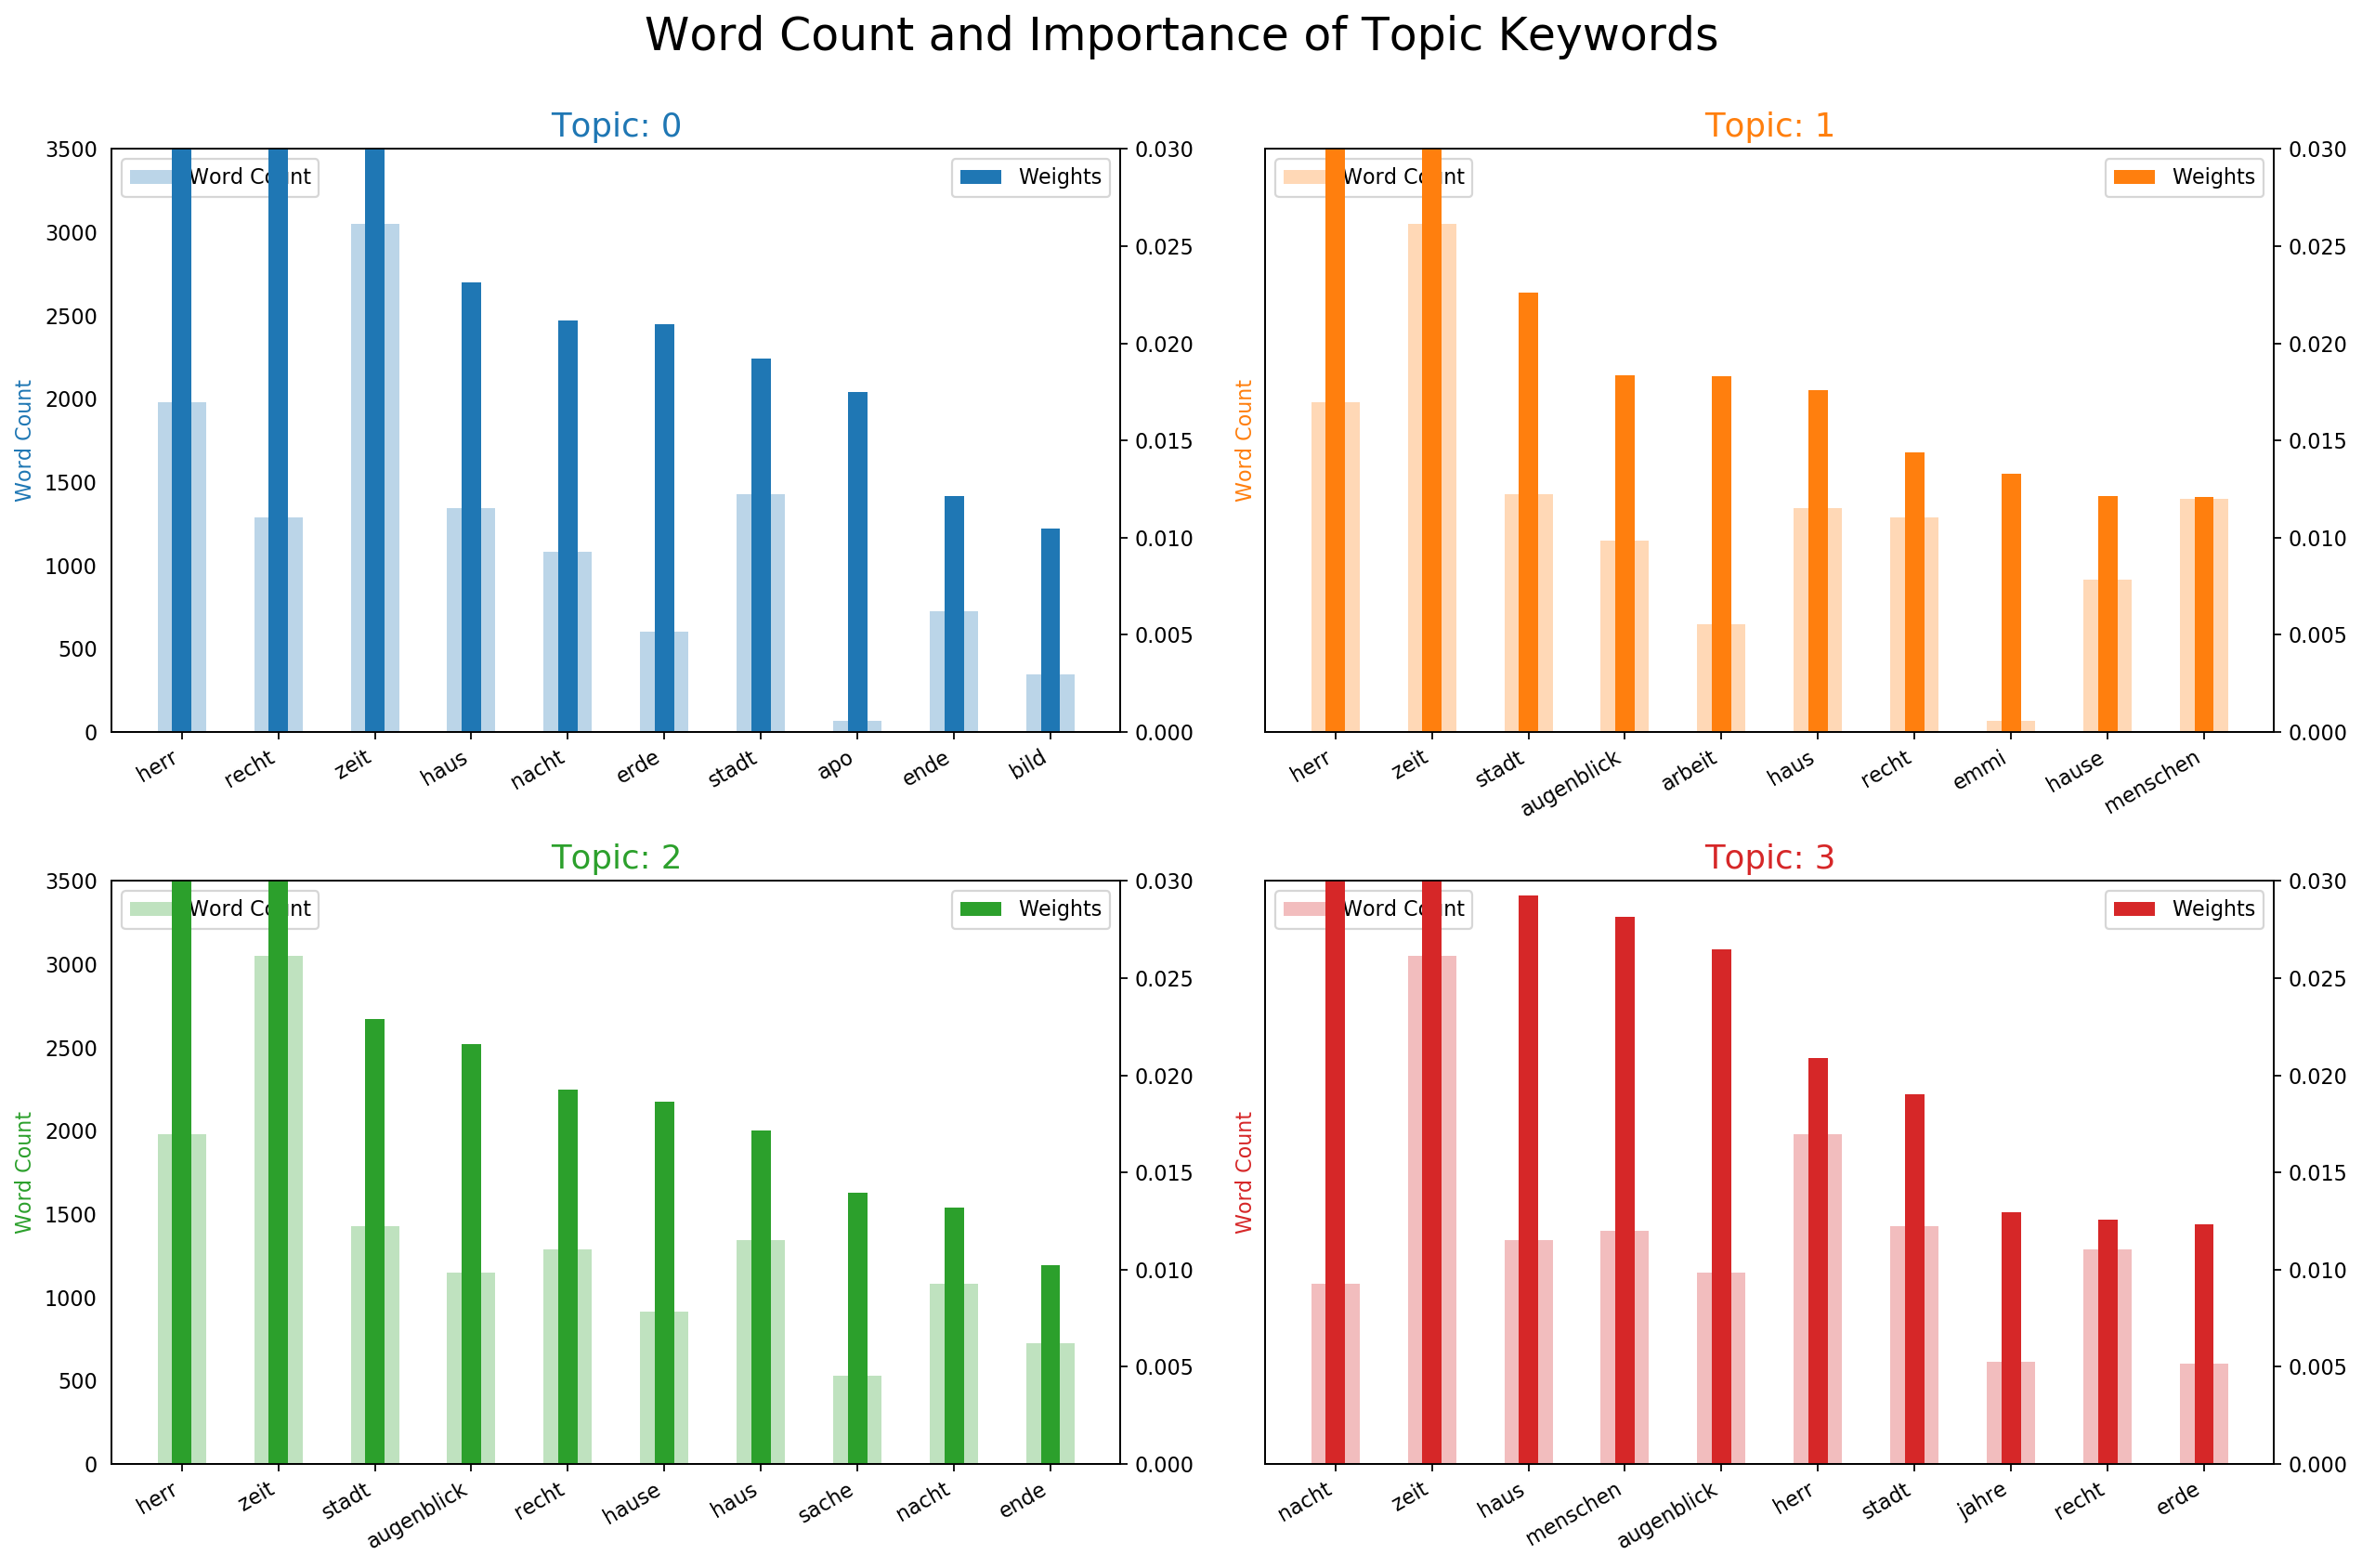

In [72]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## pyLDAVIS: Visualise the information contained in a topic

In [73]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.061694  0.043756       1        1  24.193455
7      0.062401  0.030282       2        1  18.052277
4     -0.022150  0.000147       3        1  16.943632
8     -0.029220  0.025271       4        1  12.967552
1      0.063781  0.050908       5        1   7.012157
6     -0.001499 -0.035207       6        1   6.146131
0      0.025676 -0.080105       7        1   5.237415
5     -0.049751 -0.007640       8        1   3.626461
3     -0.015761 -0.015963       9        1   3.412693
2      0.028218 -0.011450      10        1   2.408228, topic_info=     Category         Freq          Term        Total  loglift  logprob
126   Default  1768.000000          herr  1768.000000  30.0000  30.0000
177   Default  1276.000000      menschen  1276.000000  29.0000  29.0000
338   Default  2824.000000          zeit  2824.000000  28.0000  28.0000
21    Default  1030.000000    augenblick  1030.000000  27.0000  27.0000
191   Default   967.000000         nacht   967.000000  26.0000  26.0000
412   Default  1163.000000         recht  1163.000000  25.0000  25.0000
124   Default  1224.000000          haus  1224.000000  24.0000  24.0000
260   Default  1332.000000         stadt  1332.000000  23.0000  23.0000
82    Default   550.000000          erde   550.000000  22.0000  22.0000
125   Default   848.000000         hause   848.000000  21.0000  21.0000
77    Default   658.000000          ende   658.000000  20.0000  20.0000
227   Default   482.000000         sache   482.000000  19.0000  19.0000
4288  Default    52.000000           apo    52.000000  18.0000  18.0000
149   Default   559.000000         jahre   559.000000  17.0000  17.0000
276   Default   243.000000           tod   243.000000  16.0000  16.0000
16    Default   433.000000           art   433.000000  15.0000  15.0000
5084  Default    54.000000          emmi    54.000000  14.0000  14.0000
284   Default   229.000000           tur   229.000000  13.0000  13.0000
12    Default   604.000000        arbeit   604.000000  12.0000  12.0000
37    Default   317.000000          bild   317.000000  11.0000  11.0000
644   Default   210.000000       familie   210.000000  10.0000  10.0000
249   Default   284.000000        seiten   284.000000   9.0000   9.0000
133   Default   128.000000       himmels   128.000000   8.0000   8.0000
5449  Default   100.000000    fr_sonntag   100.000000   7.0000   7.0000
188   Default   201.000000         musik   201.000000   6.0000   6.0000
2519  Default    78.000000   frau_tobler    78.000000   5.0000   5.0000
332   Default   232.000000          wort   232.000000   4.0000   4.0000
207   Default   167.000000        person   167.000000   3.0000   3.0000
279   Default   126.000000         traum   126.000000   2.0000   2.0000
278   Default   145.000000           tor   145.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
126   Topic10    50.622894          herr  1768.470093   0.1728  -3.1599
2720  Topic10     0.883439  beim_anbruch     3.000652   2.5035  -7.2082
1141  Topic10     1.393082      zustehen     6.640114   2.1647  -6.7528
21    Topic10    25.766958    augenblick  1030.285645   0.0378  -3.8352
227   Topic10    16.651112         sache   482.835541   0.3591  -4.2718
125   Topic10    22.220863         hause   848.673523   0.0836  -3.9832
338   Topic10    42.024300          zeit  2824.816162  -0.4817  -3.3460
260   Topic10    27.326014         stadt  1332.228516  -0.1605  -3.7764
644   Topic10     9.777391       familie   210.083221   0.6588  -4.8042
412   Topic10    22.985620         recht  1163.364258  -0.1979  -3.9494
124   Topic10    20.477375          haus  1224.091309  -0.3644  -4.0650
191   Topic10    15.762324         nacht   967.636292  -0.3910  -4.3267
77    Topic10    12.220111          ende   658.316284  -0.2603  -4.5812
13    Topic10     6.971745           arm   186.296371   0.4408  -5.14